In [1]:
import numpy as np
import pandas as pd
from scipy.sparse.csgraph import laplacian
from numpy.linalg import inv
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from multiprocessing import Pool
import seaborn as sns
import os
import sys 
import time
import random
from tqdm import tqdm
import time
from numpy.linalg import inv
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.externals.joblib import dump
from sklearn import model_selection 
from sklearn.model_selection import GridSearchCV, cross_val_score,StratifiedKFold, learning_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import validation_curve,ShuffleSplit
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestRegressor,  RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from utils import *


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


/Users/soufiane/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
sys.version_info

sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)

# =============================================================================
# Load data
# =============================================================================

In [3]:
df = pd.read_excel('5760_simple_discriptors-SMILES.xlsx')
data = df.drop([ 'Reaction_No', 'SMILES', 'Catalyst_1_Short_Hand','SMILES_R1','SMILES_R2','SMILES','SMILES_LI','SMILES_BASE','SMILES_SOLV'], axis=1 )
data_used = data.dropna(axis=0 , how='any')

# dropping missed values
data_used = data_used.reset_index().drop('index', axis=1).copy()

# Normalization of continuous variables 
data_used['Product_Yield_PCT_Area_UV'] = data_used['Product_Yield_PCT_Area_UV']

xls = pd.ExcelFile('Descriptors for Computational Modelling.xlsx')
df_Bases = pd.read_excel(xls, 'Base_Short_Hand')
df_Solvents = pd.read_excel(xls, 'Solvent_1_Short_Hand')
df_Ligands = pd.read_excel(xls, 'Ligand_Short_Hand')

# one hot encoding
data_ohe = data_cleaning(data_used)
Y_ohe = data_ohe["Product_Yield_PCT_Area_UV"]
data_ohe = data_ohe.drop('Product_Yield_PCT_Area_UV', axis=1)
X_ohe = pd.get_dummies(data_ohe)

# discreptors
df_descr = data_discreptors(data_used,xls,df_Ligands,df_Bases,df_Solvents)
Y_just_descri = df_descr["Product_Yield_PCT_Area_UV"]
df = df_descr.drop(['Product_Yield_PCT_Area_UV',"Ligand_Short_Hand","Base_Short_Hand","Solvent_1_Short_Hand"], axis=1)
X_just_descri = pd.get_dummies(df)
df_descr = X_just_descri.copy()
df_descr["Product_Yield_PCT_Area_UV"] = Y_just_descri.copy()

In [25]:
len(data_used.iloc[df_descr.index]["Solvent_1_Short_Hand"].unique())

5

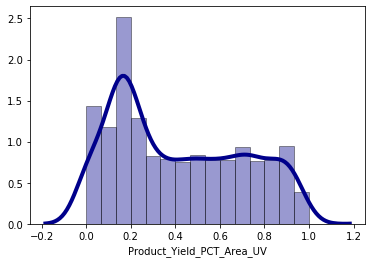

In [29]:
# Density Plot and Histogram of all arrival delays
sns.distplot(Y_just_descri/100, hist=True, kde=True,
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [6]:
data_used.shape

(5760, 6)

In [5]:
data_used["Reactant_1_Name"].unique()

array(['6-chloroquinoline', '6-Bromoquinoline', '6-triflatequinoline',
       '6-Iodoquinoline', '6-quinoline-boronic acid hydrochloride',
       'Potassium quinoline-6-trifluoroborate',
       '6-Quinolineboronic acid pinacol ester'], dtype=object)

# =============================================================================
#   Modelling with Random forest 
# ============================================================================= 

In [3]:
def fit_models(X_train, 
               X_test,
               y_train, 
               y_test,
               models=[]):
    predictions = []
    r2_values = []
    rmse_values = []
    for model in models:
        #print(model)
        # fit the model and generate predictions
        model.fit(X_train, y_train.ravel())
        preds = model.predict(X_test)

        # calculate an R-squared and RMSE values
        r_squared = r2_score(y_test, preds)
        rmse = mean_squared_error(y_test, preds) ** 0.5

        # append all to lists
        predictions.append(preds)
        r2_values.append(r_squared)
        rmse_values.append(rmse)
    #print('Done fitting models')
    return predictions, r2_values, rmse_values


# =============================================================================
# kernel computation 
# =============================================================================

In [17]:
def Have_Same_Node_At(tree,x1,x2,h):        
    t1 = tree.decision_path(x1, check_input=True).toarray()[0][h]
    t2 = tree.decision_path(x2, check_input=True).toarray()[0][h]
    return int(t1 == t2) 
    
    
    
def Kernel_Function(F,x1, x2):
    sum = 0
    for tree in F.estimators_:
        max_height = tree.tree_.node_count
        h = np.random.randint(max_height)
        if (Have_Same_Node_At(tree,x1,x2,h) == 1):
            sum = sum +1
    return sum/len(F.estimators_)

    
def Kernel_Function_2(F,x1, x2):
    SUM = 0
    K = 100  #num simulations
    for tree in F.estimators_:
        max_height = tree.tree_.node_count
        
        sum = 0
        for k in range(K):
            h = np.random.randint(max_height)           
            if (Have_Same_Node_At(tree,x1,x2,h) == 1):
                sum = sum +1
        sum = sum/K
            
                
        SUM = SUM + sum    
    return sum/len(F.estimators_)
    
    
    

def to_naive_encoding(df):
    df_numpy = df.to_numpy()
    df_np = np.argmax(df_numpy, axis = 1)
    return df_np



def index_to_tuple(index):
     return dictionary[index]
     

def compute_kernel_smart(index):
    (i,j) = index_to_tuple(index)
    x1 = X_just_descri.iloc[i].values.reshape(1, -1)
    x2 = X_just_descri.iloc[j].values.reshape(1, -1)
    return Kernel_Function_2(model, x1, x2)




# =============================================================================
# Convergence of the random forest kernel
# =============================================================================

In [77]:
def helper_function(a1,a2): 
    L = []
    for num_trees in np.arange(5,1006,100):
        models = [RandomForestRegressor(n_estimators=num_trees)]
        X_train, X_test,y_train, y_test = train_test_split(X_just_descri, Y_just_descri, train_size=0.8, random_state = 2) 
        preds, r2_values, rmse_values  = fit_models(X_train, X_test, y_train, y_test, models)
        model = models[0]
        s = Kernel_Function(model,a1,a2)
        L.append(s)
    return L


In [25]:
# Averaging 
n_simu = 50   
X_train, X_test,y_train, y_test = train_test_split(X_just_descri, Y_just_descri, train_size=0.5, random_state = 2) 
a1 = np.array(X_train.iloc[5]).reshape(1,-1)
a2 = np.array(X_train.iloc[100]).reshape(1,-1)


Av_RF_kernel = []

plt.figure(figsize=(23,6))

i=1
for _ in range(n_simu):
    simulation = helper_function(a1,a2)
    Av_RF_kernel.append(simulation)
    if i % 10 == 0:
        print("simulation : " + str(i))
    i = i+1
    

simulation : 10
simulation : 20
simulation : 30
simulation : 40
simulation : 50


<Figure size 1656x432 with 0 Axes>

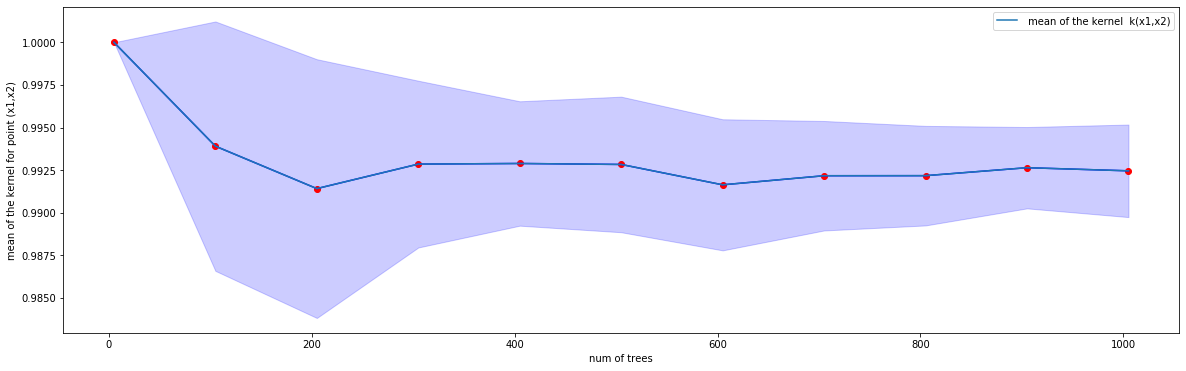

In [26]:
# plot 
av_RF_kernel = np.mean(np.array(Av_RF_kernel),axis =0)
sd__RF_kernel = np.sqrt(np.var(np.array(Av_RF_kernel),axis =0))


plt.figure(figsize=(20,6))

xfit = np.arange(5,1006,100) 

plt.plot(xfit, av_RF_kernel, 'or')
plt.plot(xfit, av_RF_kernel, '-', color='blue')
#xfit = np.arange(len(av_ohe))

plt.fill_between(xfit, av_RF_kernel - sd__RF_kernel, av_RF_kernel + sd__RF_kernel,
                 color='blue', alpha=0.2)
plt.plot(xfit, av_RF_kernel, label=' mean of the kernel  k(x1,x2)')
plt.xlabel('num of trees')
plt.ylabel('mean of the kernel for point (x1,x2)')
plt.legend()

In [ ]:
# plot 
av_RF_kernel = np.mean(np.array(Av_RF_kernel),axis =0)
sd__RF_kernel = np.sqrt(np.var(np.array(Av_RF_kernel),axis =0))


plt.figure(figsize=(20,6))

xfit = np.arange(5,1006,100) 

plt.plot(xfit, av_RF_kernel, 'or')
plt.plot(xfit, av_RF_kernel, '-', color='blue')
#xfit = np.arange(len(av_ohe))

plt.fill_between(xfit, av_RF_kernel - sd__RF_kernel, av_RF_kernel + sd__RF_kernel,
                 color='blue', alpha=0.2)
plt.plot(xfit, av_RF_kernel, label=' mean of the kernel  k(x1,x2)')
plt.xlabel('num of trees')
plt.ylabel('mean of the kernel for point (x1,x2)')
plt.legend()

# =============================================================================
#   Modelling with Gaussian process with Random forest  kernel 
# =============================================================================

In [19]:
def kernel_matrix(model, X_train_test): 
    n = X_train_test.shape[0]
    N = int(n*(n+1)/2)
    keys = range(N)
    values  = [ (a,b) for a in range(n) for b in range(a+1)]
    global dictionary
    dictionary = dict(zip(keys, values))
    


    def compute_kernel_smart(index):
        (i,j) = dictionary[index]
        x1 = X_train_test.iloc[i].values.reshape(1, -1)
        x2 = X_train_test.iloc[j].values.reshape(1, -1)
        return Kernel_Function_2(model, x1, x2)
        #return Kernel_Function(model, x1, x2)
    
    
    start_time = time.time()
    matrix = np.zeros((X_train_test.shape[0], X_train_test.shape[0]))
    p = Pool()
    #result = p.map(compute_kernel_smart, keys)
    result = p.map(getattr(sys.modules[__name__], "compute_kernel_smart"), keys)

    p.close()
    p.join()
    end_time = (time.time() - start_time)/60
    
    print(f"Processing took {end_time} min time using multiprocessing.")
    output = [x for x in result]
    
    matrix = np.zeros((X_train_test.shape[0], X_train_test.shape[0]))
    
    for index in range(N):
        (i,j) = dictionary[index]
        matrix[i,j] = output[index]
        matrix[j,i] = output[index]

    return matrix





def posterior_predictive(model,X_test, X_train, y_train, sigma_y=1e-2):
    '''  
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_test: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    
    X  =  X_train.copy()
    X  =  X.append(X_test) 

    Kernel_mat = kernel_matrix(model, X)
    error = min(np.linalg.eigvals(Kernel_mat))
    # semi_def_pos_kernel = laplacian(Kernel_mat, normed=True)
    
    
    df_kernel = pd.DataFrame(data=Kernel_mat, index=X.index,  columns = X.index)
    
    K = df_kernel.loc[X_train.index,X_train.index] +  (sigma_y**2  + abs(error) )* np.eye(len(X_train))
    #K = df_kernel.loc[X_train.index,X_train.index] +  (sigma_y**2 )*np.eye(len(X_train))
    K_s = df_kernel.loc[X_train.index,:].loc[:,X_test.index]
    K_ss = df_kernel.loc[X_test.index, X_test.index] + 1e-8 * np.eye(len(X_test))
    K_inv = inv(K)
    

    mu_s = K_s.T.dot(K_inv).dot(y_train.values)
    var_s = K_ss 
    
    return mu_s, var_s


# Compute mean and covariance of the posterior predictive distribution
#y_train_norm = y_train - np.mean(y_train)
#mu_s, cov_s = posterior_predictive(X, X_train, y_train_norm)

In [79]:
#X_train_test  = X_just_descri.head(100)

Y_just_descri_normal = (Y_just_descri - np.mean(Y_just_descri))/ np.linalg.norm(Y_just_descri)

X_train, X_test,y_train, y_test = train_test_split(X_just_descri.head(100), Y_just_descri_normal.head(100), train_size=0.8, random_state = 2) 

models = [RandomForestRegressor(n_estimators=200)]
preds, r2_values, rmse_values  = fit_models(X_train,
                                            X_test,
                                            y_train,
                                            y_test,
                                            models)
model = models[0]

## Test the kernel validity  

In [38]:
def lkhra(number_of_estimators):
    models = [RandomForestRegressor(n_estimators=number_of_estimators)]
    preds, r2_values, rmse_values  = fit_models(X_train,
                                            X_test,
                                            y_train,
                                            y_test,
                                            models)
    model = models[0]
    return model 




xfit = np.arange(5,1006,100)     
X  =  X_train.copy()
X  =  X.append(X_test)     
L = []
Time =[]
for number_of_estimators  in xfit:
    model = lkhra(number_of_estimators)
    t1 = time.time()
    mat = kernel_matrix(model, X)
    t_end = (time.time()-t1)/60 
    Time.append(t_end)
    error = min(np.linalg.eigvals(mat))
    L.append(error)

    

Processing took 0.04724537928899129 min time using multiprocessing.
Processing took 0.7310032447179159 min time using multiprocessing.
Processing took 1.4089241703351338 min time using multiprocessing.
Processing took 2.1502697785695393 min time using multiprocessing.
Processing took 2.846129790941874 min time using multiprocessing.
Processing took 3.351160689194997 min time using multiprocessing.
Processing took 4.22212400039037 min time using multiprocessing.
Processing took 5.274220160643259 min time using multiprocessing.
Processing took 6.043057386080424 min time using multiprocessing.
Processing took 6.251821498076121 min time using multiprocessing.
Processing took 6.960432744026184 min time using multiprocessing.


No handles with labels found to put in legend.


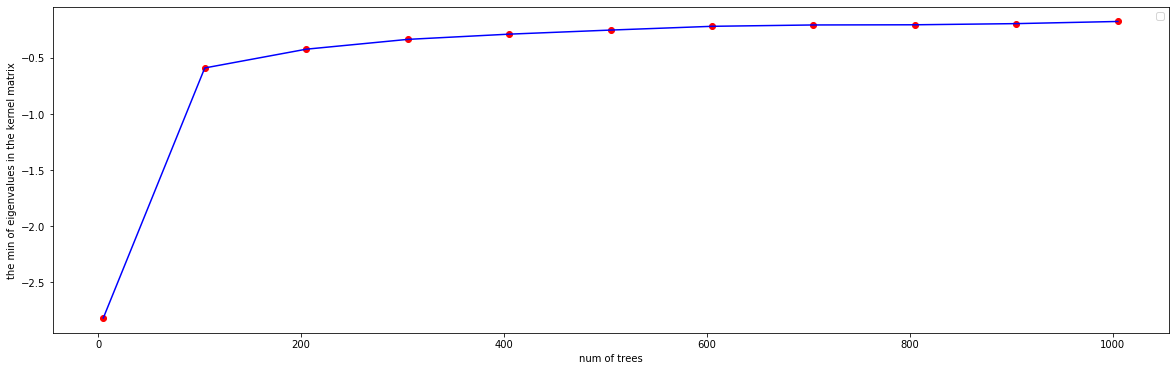

In [39]:
plt.figure(figsize=(20,6))

xfit = np.arange(5,1006,100) 

plt.plot(xfit, L, 'or')
plt.plot(xfit, L, '-', color='blue')

plt.xlabel('num of trees')
plt.ylabel('the min of eigenvalues in the kernel matrix')
plt.legend()

No handles with labels found to put in legend.


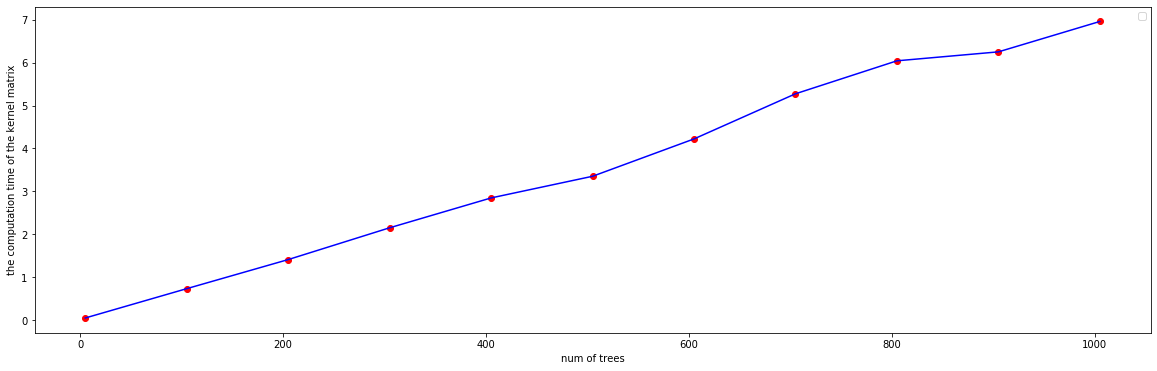

In [40]:
plt.figure(figsize=(20,6))

xfit = np.arange(5,1006,100) 

plt.plot(xfit, Time, 'or')
plt.plot(xfit, Time, '-', color='blue')

plt.xlabel('num of trees')
plt.ylabel('the computation time of the kernel matrix')
plt.legend()

## visualize the kernel matrix 

In [80]:
Y_just_descri_normal = (Y_just_descri - np.mean(Y_just_descri))

Y_ = Y_just_descri_normal.head(100)
X_ = X_just_descri.head(100)

X_train, X_test,y_train, y_test = train_test_split(X_, Y_, train_size=0.8, random_state = 2) 

models = [RandomForestRegressor(n_estimators=10)]
preds, r2_values, rmse_values  = fit_models(X_train,
                                            X_test,
                                            y_train,
                                            y_test,
                                            models)
model = models[0]
X  =  X_train.copy()
X  =  X.append(X_test) 

Kernel_mat = kernel_matrix(model, X)
df_kernel = pd.DataFrame(data=Kernel_mat, index=X.index,  columns = X.index)

idx = Y_.copy().sort_values().index

df_kernel_ordred = df_kernel.loc[idx,idx]


Processing took 0.713512639204661 min time using multiprocessing.


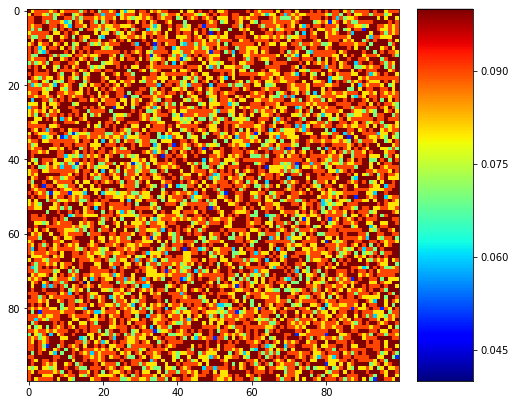

In [81]:
# Non-ordred matrix

import mpl_toolkits.axes_grid1 as axes_grid1
fig = plt.figure(figsize=(8,8))
grid = axes_grid1.AxesGrid(
    fig, 111, nrows_ncols=(1, 1), axes_pad = 0.5, cbar_location = "right",
    cbar_mode="each", cbar_size="15%", cbar_pad="5%")

im0 = grid[0].imshow(df_kernel, cmap='jet', interpolation='nearest')
grid.cbar_axes[0].colorbar(im0)

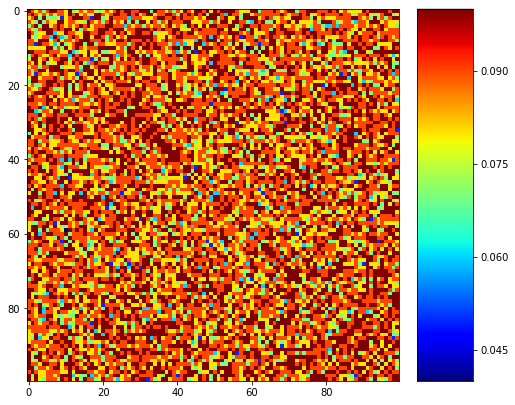

In [82]:
# ordred matrix

import mpl_toolkits.axes_grid1 as axes_grid1
fig = plt.figure(figsize=(8,8))
grid = axes_grid1.AxesGrid(
    fig, 111, nrows_ncols=(1, 1), axes_pad = 0.5, cbar_location = "right",
    cbar_mode="each", cbar_size="15%", cbar_pad="5%")

im0 = grid[0].imshow(df_kernel_ordred, cmap='jet', interpolation='nearest')
grid.cbar_axes[0].colorbar(im0)

# check the similarity ?? 

In [20]:
a1 = X_train[ y_train > max(y_train)-1 ].iloc[0].values.reshape(1,-1)
a2 = X_train[ y_train > max(y_train)-1 ].iloc[1].values.reshape(1,-1) 

b1 = X_train[ y_train < min(y_train) + 1 ].iloc[0].values.reshape(1,-1) 
b2 = X_train[ y_train < min(y_train) + 1 ].iloc[1].values.reshape(1,-1) 

print(Kernel_Function_2(model,a1, a2))
print(Kernel_Function(model,a1, a2))


print(Kernel_Function_2(model,b1, b2))
print(Kernel_Function(model,b1, b2))

print(Kernel_Function_2(model,a1, b1))
print(Kernel_Function(model,a1, b1))

0.00196
0.974
0.00196
0.952
0.00172
0.866


In [35]:
def fit_GP_RF_kernel(X_train, 
               X_test,
               y_train, 
               y_test,
               model ):

    # calculate the posterior predictive of GP with RF kernel the model and generate predictions for X_test
    
    mu_s, var_s = posterior_predictive(model,X_test, X_train, y_train, sigma_y = 1e-2)
    preds = mu_s.loc[X_test.index]
    
    # calculate an R-squared and RMSE values
    r_squared = r2_score(y_test, preds)
    rmse = mean_squared_error(y_test, preds) ** 0.5


    return preds, r_squared, rmse

In [113]:
Y_just_descri_normal = (Y_just_descri - np.mean(Y_just_descri))

X_train, X_test,y_train, y_test = train_test_split(X_just_descri.head(100), Y_just_descri_normal.head(100), train_size=0.8, random_state = 2) 

models = [RandomForestRegressor(n_estimators=100)]
preds, r2_values, rmse_values  = fit_models(X_train,
                                            X_test,
                                            y_train,
                                            y_test,
                                            models)
model = models[0]

predictions, r2_values, rmse_values = fit_GP_RF_kernel(X_train, X_test,y_train, y_test, model)


Processing took 10.065356560548146 min time using multiprocessing.


In [114]:
predictions, r2_values, rmse_values = [predictions], [r2_values], [rmse_values]  

In [115]:
def plot_models(predictions,
                r2_values,
                rmse_values,
                y_test,
                titles = ['Gaussian process with Random Forest kernel'],
                save=False):

    fig = plt.figure(figsize=(15,10))
    for pred, r2, rmse, title in zip( predictions,
                                      r2_values,
                                      rmse_values,
                                      titles):
        # create subplot
        plt.subplot()
        plt.grid(alpha=0.2)
        plt.title(title, fontsize=15)
        
        # add score patches
        r2_patch = mpatches.Patch(label="R2 = {:04.2f}".format(r2))
        rmse_patch = mpatches.Patch(label="RMSE = {:04.1f}".format(rmse))
        plt.scatter(pred, y_test.values, alpha=0.2)
        plt.legend(handles=[r2_patch, rmse_patch], fontsize=12)
        plt.plot(np.arange(2), np.arange(2), ls="--", c=".3")
        fig.text(0.5, 0.08, 'predicted yield', ha='center', va='center', fontsize=15)
        fig.text(0.09, 0.5, 'observed yield', ha='center', va='center', rotation='vertical', fontsize=15)
    if save:
        plt.savefig(save, dpi = 300)
    plt.show()
    
    

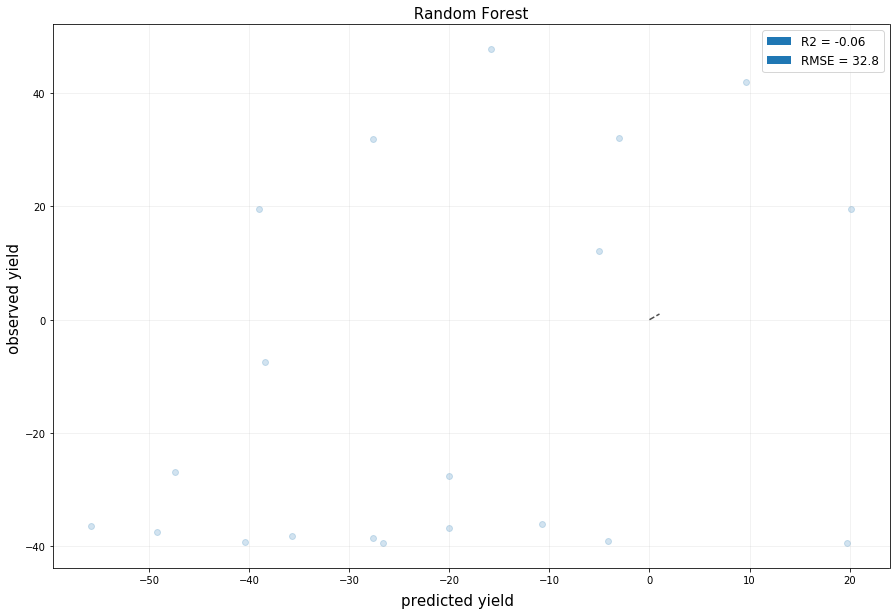

In [116]:
plot_models(predictions,
            r2_values,
            rmse_values,
            y_test,
            titles = [' Random Forest '],
            save=False)

# comparaison with random forest 

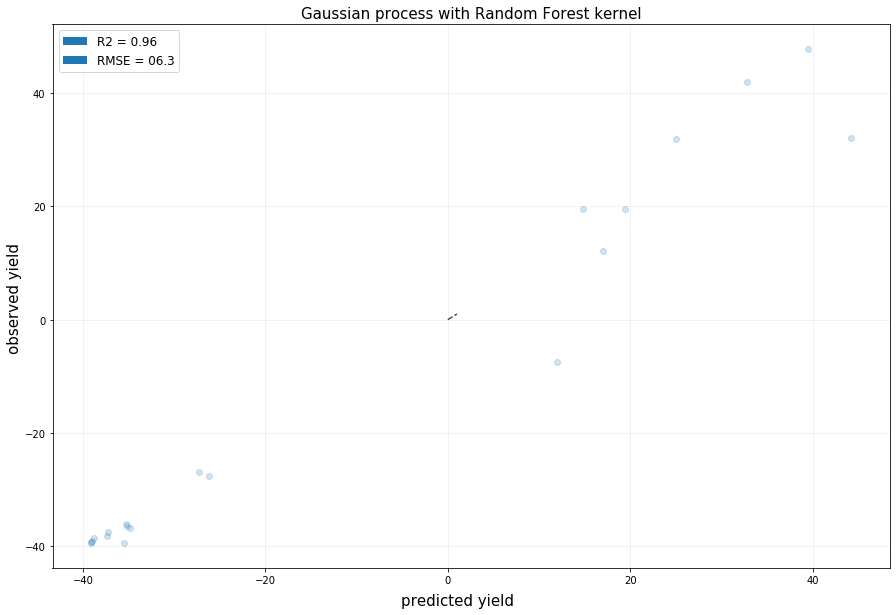

In [117]:
Y_just_descri_normal = (Y_just_descri - np.mean(Y_just_descri))

X_train, X_test,y_train, y_test = train_test_split(X_just_descri.head(100), Y_just_descri_normal.head(100), train_size=0.8, random_state = 2) 

models = [RandomForestRegressor(n_estimators=10)]
preds, r2_values, rmse_values  = fit_models(X_train,
                                            X_test,
                                            y_train,
                                            y_test,
                                            models)
model = models[0]

predictions, r2_values, rmse_values = fit_models(X_train, X_test,y_train, y_test, [model])    
plot_models(predictions,
            r2_values,
            rmse_values,
            y_test)

